#### Subject : Unsupervised Learning of Segregating News topics and visualizing those
##### Topic Modelling of New York Times News Articles, here we considered data set to be New York Times News Articles 

url : https://www.kaggle.com/datasets/benjaminawd/new-york-times-articles-comments-2020?resource=download&select=nyt-articles-2020.csv

In [1]:
#!pip install gensim
#!pip install minisom
#!pip install sumy
#!pip install sentencepiece

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import warnings

from gensim import corpora
from gensim.models import LdaModel
from gensim.models import TfidfModel
from gensim import similarities
from gensim.models import CoherenceModel

from minisom import MiniSom

from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lex_rank import LexRankSummarizer

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import sentencepiece

warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to C:\Users\Sudeshna
[nltk_data]     Kundu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
data = pd.read_csv("./nyt-articles-2020/nyt-articles-2020.csv") #loading dataset into dataframe

In [4]:
data.head()

,newsdesk,section,subsection,material,headline,abstract,keywords,word_count,pub_date,n_comments,uniqueID
0,Editorial,Opinion,NaN,Editorial,Protect Veterans From Fraud,Congress could do much more to protect America...,"['Veterans', 'For-Profit Schools', 'Financial ...",680,2020-01-01 00:18:54+00:00,186,nyt://article/69a7090b-9f36-569e-b5ab-b0ba5bb3...
1,Games,Crosswords & Games,NaN,News,‘It’s Green and Slimy’,Christina Iverson and Jeff Chen ring in the Ne...,['Crossword Puzzles'],931,2020-01-01 03:00:10+00:00,257,nyt://article/9edddb54-0aa3-5835-a833-d311a76f...
2,Science,Science,NaN,News,Meteor Showers in 2020 That Will Light Up Nigh...,"All year long, Earth passes through streams of...","['Meteors and Meteorites', 'Space and Astronom...",1057,2020-01-01 05:00:08+00:00,6,nyt://article/04bc90f0-b20b-511c-b5bb-3ce13194...
3,Science,Science,NaN,Interactive Feature,Sync your calendar with the solar system,"Never miss an eclipse, a meteor shower, a rock...","['Space and Astronomy', 'Moon', 'Eclipses', 'S...",0,2020-01-01 05:00:12+00:00,2,nyt://interactive/5b58d876-9351-50af-9b41-a312...
4,Science,Science,NaN,News,"Rocket Launches, Trips to Mars and More 2020 S...",A year full of highs and lows in space just en...,"['Space and Astronomy', 'Private Spaceflight',...",1156,2020-01-01 05:02:38+00:00,25,nyt://article/bd8647b3-8ec6-50aa-95cf-2b81ed12...


In [5]:
data.shape


(16787, 11)

In [6]:
data['newsdesk'].unique()

array(['Editorial', 'Games', 'Science', 'Foreign', 'Magazine', 'Culture',
       'Well', 'Arts&Leisure', 'RealEstate', 'SundayBusiness', 'Weekend',
       'Styles', 'Metro', 'Washington', 'Obits', 'OpEd', 'National',
       'Learning', 'Sports', 'Travel', 'Politics', 'Business', 'Podcasts',
       'Express', 'Dining', 'Opinion', 'The Upshot', 'Upshot',
       'Metropolitan', 'Insider', 'Investigative', 'Summary',
       'BookReview', 'U.S.', 'Climate', 'Books', 'Universal', 'TStyle',
       'NewsDesk', 'Arts', 'Video', 'Letters', 'Style',
       'The Learning Network', 'World', 'Smarter Living',
       'SpecialSections', 'NYTI', 'Technology', 'Gender', 'Photo',
       'Business Day', 'Live', 'Parenting', 'New York', 'Health',
       'AtHome', 'At Home', 'Food', 'NYTNow', 'Graphics', 'Movies',
       'T Magazine'], dtype=object)

In [7]:

unique_values_count = data['newsdesk'].value_counts().count()
print("Number of unique values in the column: newsdesk", unique_values_count)


Number of unique values in the column: newsdesk 63


In [8]:
unique_values_count = data['section'].nunique()
print("Number of unique values in the column: Section", unique_values_count)

Number of unique values in the column: Section 42


###### Though we have column as keywords still we would like to extract keywords from the Abstract Column, and then compute TF-IDF to find the weightage of keywords in a topic

#### Summarizing Abstract of news by Extractive Text Summarisation

In [9]:
def extractive_summarization(text, num_sentences):
    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    summarizer = LexRankSummarizer()
    summary = summarizer(parser.document, num_sentences)
    return " ".join(str(sentence) for sentence in summary)

In [10]:
processed_abstracts = []

for i in range (0,data.shape[0]):
    processed_txt = extractive_summarization(data["abstract"][i],1)
    processed_abstracts.append(processed_txt)

data["processed_abstract"] = processed_abstracts
data.head(3)

,newsdesk,section,subsection,material,headline,abstract,keywords,word_count,pub_date,n_comments,uniqueID,processed_abstract
0,Editorial,Opinion,NaN,Editorial,Protect Veterans From Fraud,Congress could do much more to protect America...,"['Veterans', 'For-Profit Schools', 'Financial ...",680,2020-01-01 00:18:54+00:00,186,nyt://article/69a7090b-9f36-569e-b5ab-b0ba5bb3...,Congress could do much more to protect America...
1,Games,Crosswords & Games,NaN,News,‘It’s Green and Slimy’,Christina Iverson and Jeff Chen ring in the Ne...,['Crossword Puzzles'],931,2020-01-01 03:00:10+00:00,257,nyt://article/9edddb54-0aa3-5835-a833-d311a76f...,Christina Iverson and Jeff Chen ring in the Ne...
2,Science,Science,NaN,News,Meteor Showers in 2020 That Will Light Up Nigh...,"All year long, Earth passes through streams of...","['Meteors and Meteorites', 'Space and Astronom...",1057,2020-01-01 05:00:08+00:00,6,nyt://article/04bc90f0-b20b-511c-b5bb-3ce13194...,"All year long, Earth passes through streams of..."


#### Preprocessing the abstract processed and headlines

Removing digits, stopwords, lowercasing and performing lemmetization

In [11]:
warnings.filterwarnings("ignore")
nlp = spacy.load("en_core_web_sm")

# Process text in DataFrame with spaCy

df = data[["abstract","processed_abstract","headline"]]
# Add index column
indexed_documents = [(i, doc) for i, doc in enumerate(df["headline"])]
df["Document_ID"] = indexed_documents

stop_words = set(stopwords.words('english'))
preprocessed_texts = [" ".join([word.lower() for word in word_tokenize(doc) if word.isalpha() and word.lower() not in stop_words]) for doc in df["processed_abstract"]]

# Update DataFrame with processed text
df["processed_texts"] = preprocessed_texts
df.head(3)

,abstract,processed_abstract,headline,Document_ID,processed_texts
0,Congress could do much more to protect America...,Congress could do much more to protect America...,Protect Veterans From Fraud,"(0, Protect Veterans From Fraud)",congress could much protect americans served c...
1,Christina Iverson and Jeff Chen ring in the Ne...,Christina Iverson and Jeff Chen ring in the Ne...,‘It’s Green and Slimy’,"(1, ‘It’s Green and Slimy’)",christina iverson jeff chen ring new year
2,"All year long, Earth passes through streams of...","All year long, Earth passes through streams of...",Meteor Showers in 2020 That Will Light Up Nigh...,"(2, Meteor Showers in 2020 That Will Light Up ...",year long earth passes streams cosmic debris


#### Tokenizing the processed_texts

In [12]:
tokenized_texts = []

for text in df["processed_texts"]:
    tokenized_docs = text.lower().split()
    tokenized_texts.append(tokenized_docs)

Put the tokenize text in the dataframe

In [13]:
df["Tokenized_text"] = tokenized_texts
df.head(3)

,abstract,processed_abstract,headline,Document_ID,processed_texts,Tokenized_text
0,Congress could do much more to protect America...,Congress could do much more to protect America...,Protect Veterans From Fraud,"(0, Protect Veterans From Fraud)",congress could much protect americans served c...,"[congress, could, much, protect, americans, se..."
1,Christina Iverson and Jeff Chen ring in the Ne...,Christina Iverson and Jeff Chen ring in the Ne...,‘It’s Green and Slimy’,"(1, ‘It’s Green and Slimy’)",christina iverson jeff chen ring new year,"[christina, iverson, jeff, chen, ring, new, year]"
2,"All year long, Earth passes through streams of...","All year long, Earth passes through streams of...",Meteor Showers in 2020 That Will Light Up Nigh...,"(2, Meteor Showers in 2020 That Will Light Up ...",year long earth passes streams cosmic debris,"[year, long, earth, passes, streams, cosmic, d..."


#### Computing TF-IDF representation

In [14]:
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df["processed_texts"])

# Computing cosine similarity
similarity_matrix= cosine_similarity(tfidf_matrix, tfidf_matrix)

# Printing similarity matrix
print("Cosine Similarity Matrix:")
print(similarity_matrix)

Cosine Similarity Matrix:
[[1.         0.         0.         ... 0.         0.         0.        ]
 [0.         1.         0.05915521 ... 0.         0.02668521 0.        ]
 [0.         0.05915521 1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.         0.10181238]
 [0.         0.02668521 0.         ... 0.         1.         0.        ]
 [0.         0.         0.         ... 0.10181238 0.         1.        ]]


In [15]:
# Convert similarity matrix to DataFrame
similarity_df = pd.DataFrame(similarity_matrix, columns=[df["Document_ID"]], index=[df["Document_ID"]])



In [16]:
# Printing first rows of similarity dataFrame
similarity_df.head()

Document_ID,"(0, Protect Veterans From Fraud)","(1, ‘It’s Green and Slimy’)","(2, Meteor Showers in 2020 That Will Light Up Night Skies)","(3, Sync your calendar with the solar system)","(4, Rocket Launches, Trips to Mars and More 2020 Space and Astronomy Events)","(5, Pro-Iranian Protesters End Siege of U.S. Embassy in Baghdad)","(6, Judge John Hodgman on Uncle Money Bags)","(7, She Felt Fine, but Her M.R.I. Showed Several Strokes. What Was Wrong?)","(8, These Armenian Flatbreads Stuffed With Greens Are the Perfect Snack)","(9, ‘Don’t Believe a Word,’ a Look at Language and Power (and Why Dolphins Have Accents))",...,"(16777, Homes for Sale in New York and Connecticut)","(16778, Homes for Sale in Brooklyn, Manhattan and Staten Island)","(16779, Becky Hammon Becomes First Woman to Serve as Head Coach in N.B.A. Game)","(16780, Superheroes and Trailblazers: Black Comic Book Artists, Rediscovered)","(16781, Here’s Why Distribution of the Vaccine Is Taking Longer Than Expected)","(16782, What It Takes to Heal From Covid-19)","(16783, Padres Jolt M.L.B. With Bold Moves to Set Up World Series Run)","(16784, Their Finances Ravaged, Customers Fear Banks Will Withhold Stimulus Checks)","(16785, Should Wine Be Among Your Health Resolutions?)","(16786, Microsoft Says Russian Hackers Viewed Some of Its Source Code)"
Document_ID,,,,,,,,,,,,,,,,,,,,,
"(0, Protect Veterans From Fraud)",1.0,0.000000,0.000000,0.000000,0.000000,0.054836,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
"(1, ‘It’s Green and Slimy’)",0.0,1.000000,0.059155,0.000000,0.065580,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.020228,0.0,0.0,0.000000,0.0,0.026685,0.0
"(2, Meteor Showers in 2020 That Will Light Up Night Skies)",0.0,0.059155,1.000000,0.000000,0.043868,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
"(3, Sync your calendar with the solar system)",0.0,0.000000,0.000000,1.000000,0.052099,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.025183,0.0,0.000000,0.0
"(4, Rocket Launches, Trips to Mars and More 2020 Space and Astronomy Events)",0.0,0.065580,0.043868,0.052099,1.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.015001,0.0,0.0,0.000000,0.0,0.019789,0.0


In [17]:
# Printing last rows of similarity dataframe 
similarity_df.tail()

Document_ID,"(0, Protect Veterans From Fraud)","(1, ‘It’s Green and Slimy’)","(2, Meteor Showers in 2020 That Will Light Up Night Skies)","(3, Sync your calendar with the solar system)","(4, Rocket Launches, Trips to Mars and More 2020 Space and Astronomy Events)","(5, Pro-Iranian Protesters End Siege of U.S. Embassy in Baghdad)","(6, Judge John Hodgman on Uncle Money Bags)","(7, She Felt Fine, but Her M.R.I. Showed Several Strokes. What Was Wrong?)","(8, These Armenian Flatbreads Stuffed With Greens Are the Perfect Snack)","(9, ‘Don’t Believe a Word,’ a Look at Language and Power (and Why Dolphins Have Accents))",...,"(16777, Homes for Sale in New York and Connecticut)","(16778, Homes for Sale in Brooklyn, Manhattan and Staten Island)","(16779, Becky Hammon Becomes First Woman to Serve as Head Coach in N.B.A. Game)","(16780, Superheroes and Trailblazers: Black Comic Book Artists, Rediscovered)","(16781, Here’s Why Distribution of the Vaccine Is Taking Longer Than Expected)","(16782, What It Takes to Heal From Covid-19)","(16783, Padres Jolt M.L.B. With Bold Moves to Set Up World Series Run)","(16784, Their Finances Ravaged, Customers Fear Banks Will Withhold Stimulus Checks)","(16785, Should Wine Be Among Your Health Resolutions?)","(16786, Microsoft Says Russian Hackers Viewed Some of Its Source Code)"
Document_ID,,,,,,,,,,,,,,,,,,,,,
"(16782, What It Takes to Heal From Covid-19)",0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,1.0,0.0,0.000000,0.0,0.000000
"(16783, Padres Jolt M.L.B. With Bold Moves to Set Up World Series Run)",0.0,0.000000,0.0,0.025183,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.044826,0.000000,0.0,0.0,1.0,0.000000,0.0,0.000000
"(16784, Their Finances Ravaged, Customers Fear Banks Will Withhold Stimulus Checks)",0.0,0.000000,0.0,0.000000,0.000000,0.038728,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,1.000000,0.0,0.101812
"(16785, Should Wine Be Among Your Health Resolutions?)",0.0,0.026685,0.0,0.000000,0.019789,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.019689,0.0,0.0,0.0,0.000000,1.0,0.000000
"(16786, Microsoft Says Russian Hackers Viewed Some of Its Source Code)",0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.101812,0.0,1.000000


###### Estimating optimized cluster count in K-Means

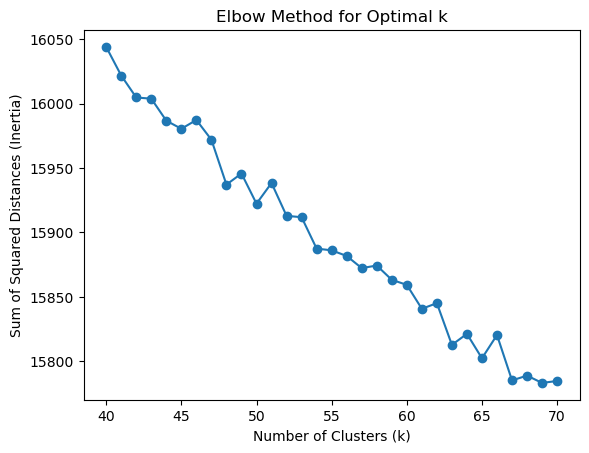

In [18]:
k_values = range(40, 71)
inertia_values = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tfidf_matrix)
    inertia_values.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(k_values, inertia_values, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances (Inertia)')

# Show the plot
plt.show()

###### We can say that, optimal number of clusters is 43

#### Creating clusters based on similarity

In [19]:
num_clusters = 43        # Example number of clusters
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(similarity_matrix)
clusters = kmeans.labels_

In [20]:
# Interpret Clusters as Topics
topics = {}
for i in range(num_clusters):
    topics[i] = [indexed_documents[j][1] for j, cluster_label in enumerate(clusters) if cluster_label == i]
    

##### Examples of few documents in few clusters

###### Documents in Cluster 1  are shown below

In [21]:
print("\n Topic Set-1 -->\n")
for item in topics[0]:
    print(item)


 Topic Set-1 -->

‘It’s Green and Slimy’
Rocket Launches, Trips to Mars and More 2020 Space and Astronomy Events
‘Surviving R. Kelly’ Night One Recap: Threats and New Abuse Details
Turkey, Flexing Its Muscles, Will Send Troops to Libya
Which Subway Seat Is Best? Your Answer Is Obviously Wrong
Why Your Uber Ride Can Cost as Much as a Plane Ticket
So You Want to Join Your Co-op Board?
A History of War in Six Drugs
United Methodist Church Announces Plan to Split Over Same-Sex Marriage
3 … 2 … 1. Then Their Real Countdown Began.
How to Deal With January Crowds at the Gym
To Fight Climate Change, One City May Ban Heating Homes With Natural Gas
How the Lady Became Less Gray
An Open Letter to John Lewis
Harvey Weinstein Charged With Rape in Los Angeles as N.Y. Trial Starts
Reimagining Old Friends at the National Theater in London
The Superpowers of Super-Thin Materials
Gen X Women: More Opportunities, Less Satisfaction?
The Nets Called It Home. Now an NBC Drama Lives There.
McConnell Says He

###### Documents in Cluster 2 are shown below

In [22]:
print("\n Topic Set-2 -->\n")
for item in topics[1]:
    print(item)


 Topic Set-2 -->

Pro-Iranian Protesters End Siege of U.S. Embassy in Baghdad
The Titans Slew a Giant. Can They Take Down Another?
Iran Cracks Down as Protests Over Downing of Airliner Grow
The Book That Changed My Life
Trump Acts Like a Politician. That’s Not an Impeachable Offense.
Latin America’s Radical Feminism Is Spreading
Chuck Schumer on Impeachment, Witnesses and the Truth
Will Someone Break Out of Iowa Who Can Trounce Trump? Anyone?
‘All-Electric’ Movement Picks Up Speed, Catching Some Off Guard
She Wants to Break Up Big Everything
How Cooking Dinner Can Change Your Life
How ‘Portrait of a Lady on Fire’ Sees Power in Two Women in Love
This Is How Scandinavia Got Great
Gender Pronouns Can Be Tricky on Campus. Harvard Is Making Them Stick.
Why Tales of Female Trios Are Newly Relevant
Women-Powered Weddings on Rise
Kerik Had ‘Hit Bottom.’ Then Trump Pardoned Him.
Katie Roiphe Feels Ambivalent About Feeling Ambivalent
Democrats Are Ignoring the Voters Who Could Decide This Elect

###### Documents in Cluster 26 are shown below

In [23]:
print("\n Topic Set-26 -->\n")
for item in topics[25]:
    print(item)


 Topic Set-26 -->

Variety: Acrostic
Variety: Acrostic
Variety: Acrostic
Variety: Acrostic
Variety: Acrostic
Variety: Acrostic
Variety: Acrostic
Variety: Acrostic
Variety: Acrostic
Variety: Acrostic
Variety: Acrostic
Variety: Acrostic
Variety: Acrostic
Variety: Acrostic
Variety: Acrostic
Variety: Acrostic
Variety: Acrostic
Variety: Cryptic Crossword
Variety: Acrostic
Variety: Acrostic
Variety: Acrostic
Variety: Acrostic
Variety: Acrostic
Variety: Acrostic
Variety: Acrostic
Variety: Acrostic
Variety: Acrostic
Variety: Cryptic Crossword


###### Documents in Cluster 6 are shown below

In [24]:
print("\n Topic Set-6 -->\n")
for item in topics[5]:
    print(item)


 Topic Set-6 -->

Suleimani Died as He Had Killed
Defenders of History Take Aim at Trump’s Threat to Strike Iran’s Cultural Sites
The Crucial Lessons From Australia’s Wildfires
As Iran and U.S. Trade Blows, Afghanistan Sweats Between the 2 Powers
‘How Much Did Killing Suleimani Cost Us?’
Why Your State Is Growing or Stalling or Shrinking
After California Law, Statehouses Push to Expand Rights of College Athletes
U.S. Says China Is No Longer a Currency Manipulator
A Trade Deal Meant to Heal Rifts Could Actually Make Them Worse
Iran’s Supreme Leader Rebukes U.S. in Rare Friday Sermon
Facebook Political Ads: Which States Are 2020 Democrats Betting On?
The Test a Deadly Coronavirus Outbreak Poses to China’s Leadership
Iran Admits Firing 2 Missiles at Jet and Says It’s Studying Effect
A New Face of White Supremacy: Plots Expose Danger of the ‘Base’
Trump Moves to Block Visas for Pregnant Women on ‘Birth Tourism’
34 Troops Have Brain Injuries From Iranian Missile Strike, Pentagon Says
The O

###### Documents in Cluster 49 are shown below

In [25]:
print("\n Topic Set-43 -->\n")
for item in topics[42]:
    print(item)


 Topic Set-43 -->

What’s Going On in This Picture? | Jan. 6, 2020
What’s Going On in This Picture? | Jan. 13, 2020
What’s Going On in This Picture? | Jan. 27, 2020
What’s Going On in This Picture? | Feb. 3, 2020
What’s Going On in This Picture? | Feb. 10, 2020
What’s Going On in This Picture? | Feb. 24, 2020
What’s Going On in This Picture? | March 2, 2020
What’s Going On in This Picture? | March 9, 2020
What’s Going On in This Picture? | March 16, 2020
What’s Going On in This Picture? | March 23, 2020
What’s Going On in This Picture? | March 30, 2020
What’s Going On in This Picture? | April 6, 2020
What’s Going On in This Picture? | April 13, 2020
What’s Going On in This Picture? | April 20, 2020
What’s Going On in This Picture? | April 27, 2020
What’s Going On in This Picture? | May 4, 2020
What’s Going On in This Picture? | May 11, 2020
What’s Going On in This Picture? | May 18, 2020
What’s Going On in This Picture? | Sept. 14, 2020
What’s Going On in This Picture? | Sept. 21, 202

#### Now, we want to compute the quality of clusters created by K-Means. We can do it by Keyword Extraction.

Keyword Extraction: Extracting keywords from each cluster and analyzing their relevance and coherence can provide qualitative insights into the quality of the topics generated by K-means. You can calculate metrics such as word frequency, TF-IDF scores, or coherence scores based on word co-occurrence to assess the quality of the topics.

#### Now, From all clusters, finding the maximum tf-idf score for each clusters and count of abstracts 

In [26]:

max_tfidf_words_per_cluster = []

for cluster_label in range(43):
                                                            # Filter documents belonging to the cluster
    cluster_indices = np.where(kmeans.labels_ == cluster_label)[0]
    cluster_tfidf_scores = tfidf_matrix[cluster_indices].sum(axis=0).A1
                                                       # Get indices of words with maximum TF-IDF scores in the cluster
    max_tfidf_word_indices = np.argsort(cluster_tfidf_scores)[::-1][:1]  # Get top 1 word
    
                                                               # Get the actual words from the vocabulary
    max_tfidf_words = [vectorizer.get_feature_names_out()[i] for i in max_tfidf_word_indices]
                                                  # Append the list of words with maximum TF-IDF scores to the result list
    max_tfidf_words_per_cluster.append((cluster_label, max_tfidf_words[0]))

    # Printing the words with maximum TF-IDF score in each cluster
for cluster_label, max_tfidf_words in max_tfidf_words_per_cluster:
    print(f"Cluster {cluster_label}: Words with maximum TF-IDF scores - {max_tfidf_words}")


Cluster 0: Words with maximum TF-IDF scores - new
Cluster 1: Words with maximum TF-IDF scores - power
Cluster 2: Words with maximum TF-IDF scores - los
Cluster 3: Words with maximum TF-IDF scores - time
Cluster 4: Words with maximum TF-IDF scores - stock
Cluster 5: Words with maximum TF-IDF scores - states
Cluster 6: Words with maximum TF-IDF scores - still
Cluster 7: Words with maximum TF-IDF scores - house
Cluster 8: Words with maximum TF-IDF scores - coronavirus
Cluster 9: Words with maximum TF-IDF scores - york
Cluster 10: Words with maximum TF-IDF scores - many
Cluster 11: Words with maximum TF-IDF scores - world
Cluster 12: Words with maximum TF-IDF scores - first
Cluster 13: Words with maximum TF-IDF scores - pandemic
Cluster 14: Words with maximum TF-IDF scores - diary
Cluster 15: Words with maximum TF-IDF scores - president
Cluster 16: Words with maximum TF-IDF scores - right
Cluster 17: Words with maximum TF-IDF scores - lesson
Cluster 18: Words with maximum TF-IDF scores - g

In [27]:
articles_per_cluster = np.bincount(kmeans.labels_)   #Counting the number of articles in each cluster
for cluster_label, num_articles in enumerate(articles_per_cluster):
    print(f"Cluster {cluster_label}: Number of articles = {num_articles}")

Cluster 0: Number of articles = 809
Cluster 1: Number of articles = 85
Cluster 2: Number of articles = 54
Cluster 3: Number of articles = 236
Cluster 4: Number of articles = 58
Cluster 5: Number of articles = 228
Cluster 6: Number of articles = 119
Cluster 7: Number of articles = 190
Cluster 8: Number of articles = 21
Cluster 9: Number of articles = 420
Cluster 10: Number of articles = 8072
Cluster 11: Number of articles = 292
Cluster 12: Number of articles = 255
Cluster 13: Number of articles = 125
Cluster 14: Number of articles = 51
Cluster 15: Number of articles = 485
Cluster 16: Number of articles = 102
Cluster 17: Number of articles = 140
Cluster 18: Number of articles = 28
Cluster 19: Number of articles = 13
Cluster 20: Number of articles = 58
Cluster 21: Number of articles = 280
Cluster 22: Number of articles = 729
Cluster 23: Number of articles = 45
Cluster 24: Number of articles = 155
Cluster 25: Number of articles = 28
Cluster 26: Number of articles = 422
Cluster 27: Number o

#### Creating a dataframe with topic names and topic number and count of articles 

In [28]:
K_Means_Quality_df = pd.DataFrame(max_tfidf_words_per_cluster)
K_Means_Quality_df["Articles_per_Cluster"] = articles_per_cluster
K_Means_Quality_df.rename(columns={0: 'Cluster_ID', 1: 'Topic'},inplace=True)

K_Means_Quality_df.head()

,Cluster_ID,Topic,Articles_per_Cluster
0,0,new,809
1,1,power,85
2,2,los,54
3,3,time,236
4,4,stock,58


#### Plotting a bargraph of topics vs Count of articles pre K-Means Clustering on original dataset

       section  Count of Abstract
0        Admin                  1
1         Arts               1094
2      At Home                  5
3  Automobiles                  1
4        Books                371


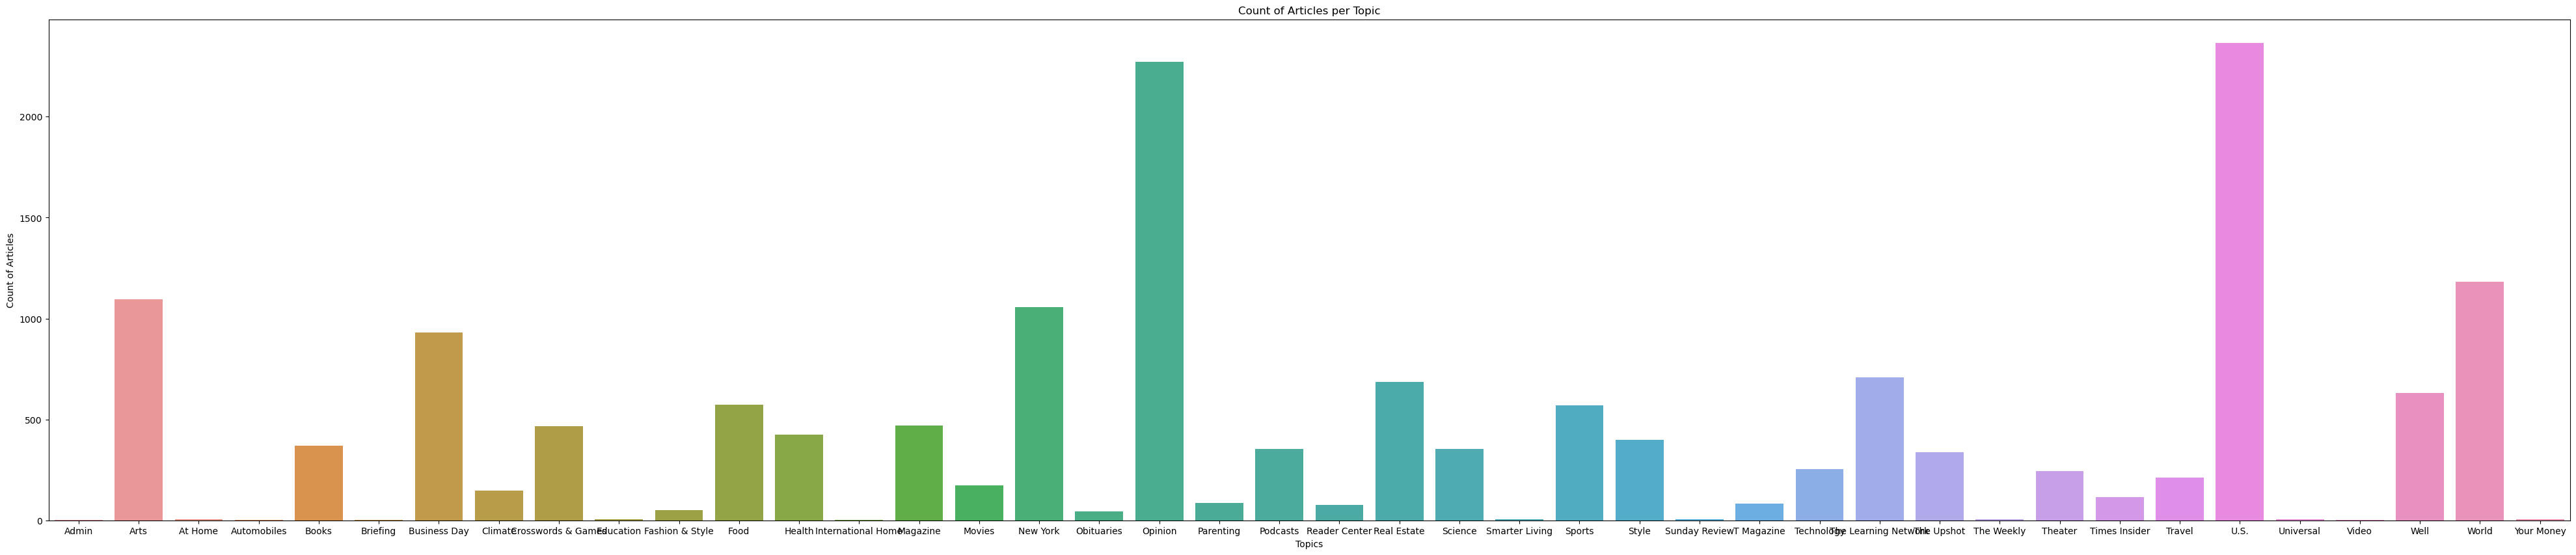

In [29]:
d = data.groupby('section').agg({'abstract': 'count'}).reset_index()
d.rename(columns={'abstract': 'Count of Abstract'},inplace=True)
print(d.head())
# Plotting the bar graph
plt.figure(figsize=(50, 10))                              
sns.barplot(x='section', y='Count of Abstract', data=d)


# Adding labels and title
plt.xlabel('Topics')
plt.ylabel('Count of Articles')
plt.title('Count of Articles per Topic')

# Show the plot
plt.show()

#### Plotting a bargraph of topics vs Count of articles post K-Means Clustering

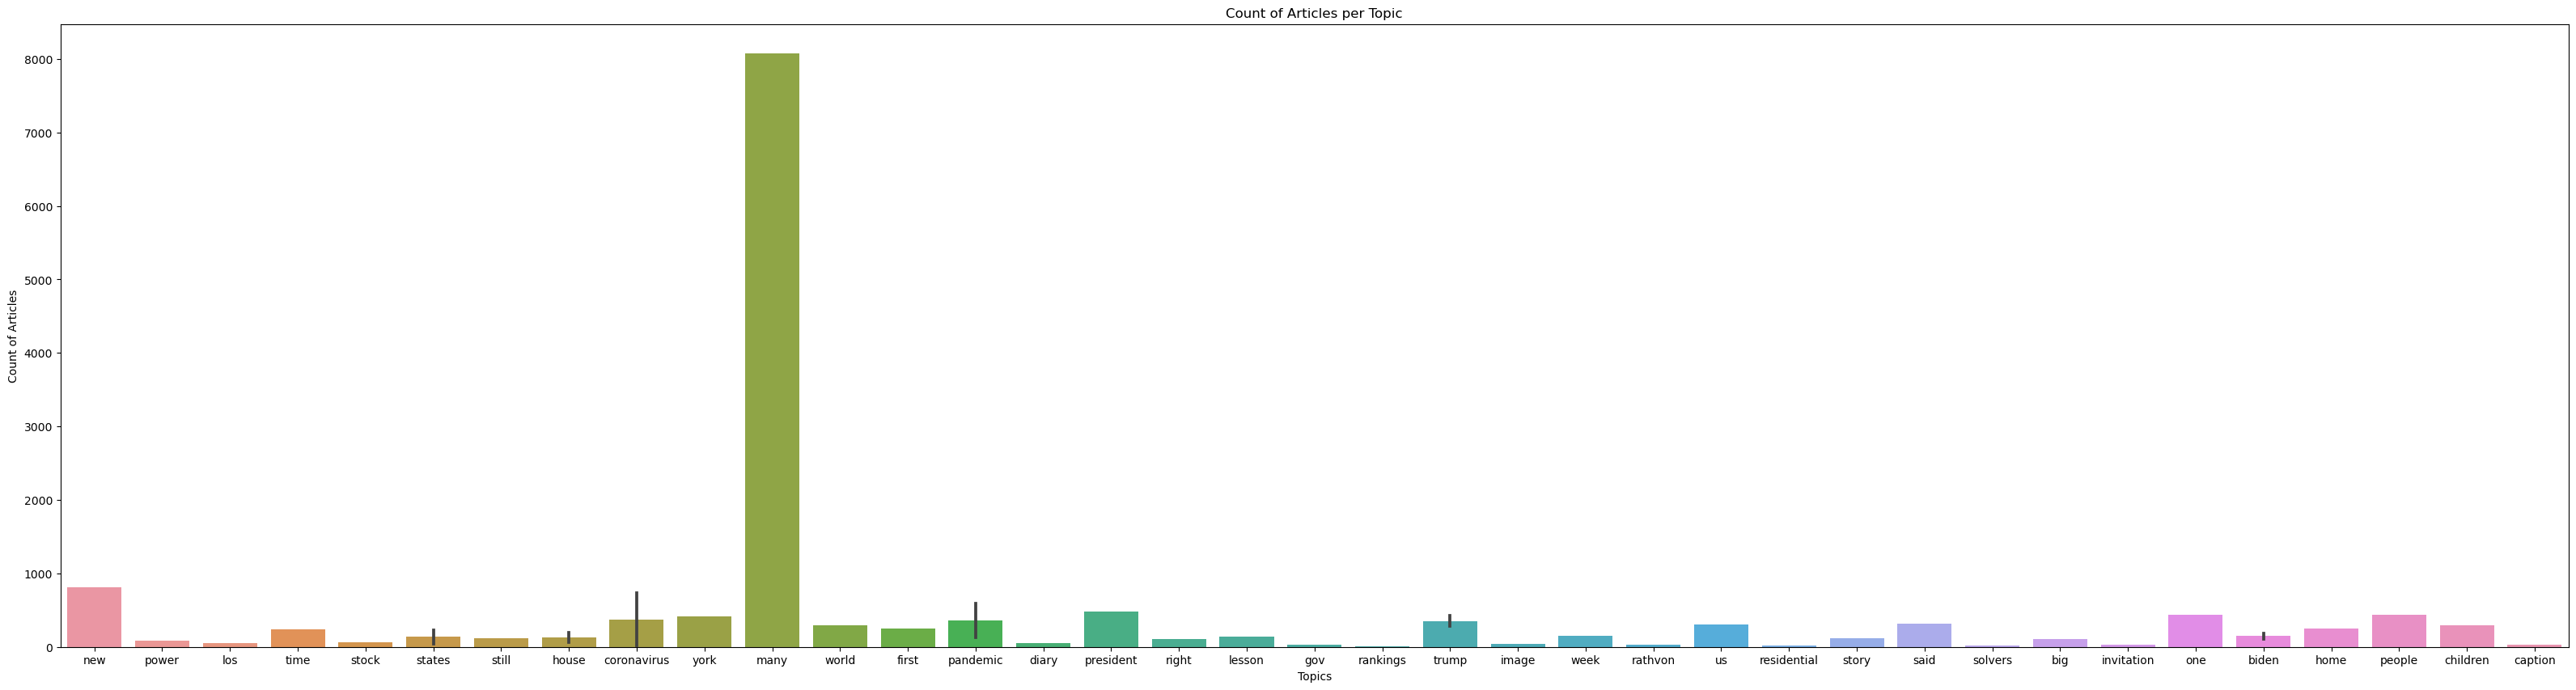

In [30]:
# Plotting the bar graph
plt.figure(figsize=(40, 10))                              
sns.barplot(x='Topic', y='Articles_per_Cluster', data=K_Means_Quality_df)


# Adding labels and title
plt.xlabel('Topics')
plt.ylabel('Count of Articles')
plt.title('Count of Articles per Topic')

# Show the plot
plt.show()

With K-Means , we can interpret that K-Means doesnot do much good in clustering with TF-IDF and similarity of articles, If we see the clusters we donot see that it matches with sections which were predefined in the dataset.

# Computing LDA using TF-IDF


Previously we saw how clusters were formed with cosine similarity & TF-IDF values, Now we want to see how LDA (Latent Dirichlet Allocation) helps in topic modelling

What is LDA?

###### Latent Dirichlet Allocation (LDA) is a generative probabilistic model used for topic modeling in text data. It assumes that documents are made up of a mixture of topics, and each word in a document is generated by one of the topics. LDA aims to uncover these latent topics from a collection of documents.

#### LDA considers two important parameters

1.Document-topic distribution : Each row represents a document, and each column represents a topic. Initialize these probabilities randomly.        
2.Topic-word distribution : Each row represents a topic, and each column represents a word in the vocabulary. Initialize these probabilities randomly.       

Iterate over each document in the corpus

For each word in the document:                                                                              
Calculate the probability of each topic being the source of the word, given the current state of the model. This is done by multiplying the probability of the word given the topic with the probability of the topic given the document.

Sample a new topic assignment for the word based on these probabilities.                                                       
Update the document-topic distribution and topic-word distribution  based on the new topic assignments.                         


Repeat the iterative process until the model converges, meaning that the topics and their distributions stabilize and don't change significantly between iterations.

### Implementing Latent Dirichlet Allocation

Creating a dictionary and TF-IDF model

In [31]:
dictionary = corpora.Dictionary(tokenized_texts)
corpus = [dictionary.doc2bow(doc) for doc in tokenized_texts]

#### Training the LDA model

In [32]:
lda_model = LdaModel(corpus, num_topics=43, id2word=dictionary, passes=10)

#### Printing topics

In [33]:
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx}: {topic}")

Topic 0: 0.073*"help" + 0.041*"nation" + 0.038*"keep" + 0.035*"top" + 0.035*"ways" + 0.030*"businesses" + 0.023*"vote" + 0.023*"voting" + 0.019*"elections" + 0.017*"spring"
Topic 1: 0.058*"family" + 0.046*"story" + 0.040*"shows" + 0.040*"news" + 0.037*"lost" + 0.028*"support" + 0.025*"access" + 0.019*"set" + 0.019*"critics" + 0.018*"tell"
Topic 2: 0.076*"say" + 0.052*"vaccine" + 0.043*"among" + 0.036*"death" + 0.031*"experts" + 0.023*"service" + 0.022*"led" + 0.021*"thousands" + 0.021*"growing" + 0.018*"whose"
Topic 3: 0.096*"home" + 0.067*"house" + 0.031*"working" + 0.029*"politics" + 0.027*"star" + 0.027*"music" + 0.026*"woman" + 0.023*"helped" + 0.023*"give" + 0.022*"congress"
Topic 4: 0.057*"children" + 0.056*"social" + 0.047*"season" + 0.033*"outbreak" + 0.032*"live" + 0.031*"market" + 0.029*"media" + 0.023*"career" + 0.020*"others" + 0.020*"coronavirus"
Topic 5: 0.100*"election" + 0.047*"might" + 0.040*"end" + 0.024*"summer" + 0.023*"using" + 0.022*"research" + 0.021*"british" + 

#### Optionally, print the dominant topic for each document

In [34]:
for i, article in enumerate(tokenized_texts):
    print(f"Article {i+1} - Dominant Topic: {lda_model.get_document_topics(corpus[i])[0][0]}")

Article 1 - Dominant Topic: 3
Article 2 - Dominant Topic: 18
Article 3 - Dominant Topic: 8
Article 4 - Dominant Topic: 4
Article 5 - Dominant Topic: 10
Article 6 - Dominant Topic: 1
Article 7 - Dominant Topic: 18
Article 8 - Dominant Topic: 3
Article 9 - Dominant Topic: 8
Article 10 - Dominant Topic: 1
Article 11 - Dominant Topic: 2
Article 12 - Dominant Topic: 2
Article 13 - Dominant Topic: 4
Article 14 - Dominant Topic: 18
Article 15 - Dominant Topic: 3
Article 16 - Dominant Topic: 2
Article 17 - Dominant Topic: 4
Article 18 - Dominant Topic: 1
Article 19 - Dominant Topic: 1
Article 20 - Dominant Topic: 0
Article 21 - Dominant Topic: 7
Article 22 - Dominant Topic: 16
Article 23 - Dominant Topic: 0
Article 24 - Dominant Topic: 0
Article 25 - Dominant Topic: 11
Article 26 - Dominant Topic: 1
Article 27 - Dominant Topic: 1
Article 28 - Dominant Topic: 18
Article 29 - Dominant Topic: 1
Article 30 - Dominant Topic: 4
Article 31 - Dominant Topic: 5
Article 32 - Dominant Topic: 0
Article 33

Article 824 - Dominant Topic: 2
Article 825 - Dominant Topic: 4
Article 826 - Dominant Topic: 5
Article 827 - Dominant Topic: 4
Article 828 - Dominant Topic: 19
Article 829 - Dominant Topic: 16
Article 830 - Dominant Topic: 5
Article 831 - Dominant Topic: 26
Article 832 - Dominant Topic: 1
Article 833 - Dominant Topic: 4
Article 834 - Dominant Topic: 2
Article 835 - Dominant Topic: 7
Article 836 - Dominant Topic: 11
Article 837 - Dominant Topic: 22
Article 838 - Dominant Topic: 2
Article 839 - Dominant Topic: 2
Article 840 - Dominant Topic: 2
Article 841 - Dominant Topic: 0
Article 842 - Dominant Topic: 3
Article 843 - Dominant Topic: 2
Article 844 - Dominant Topic: 3
Article 845 - Dominant Topic: 3
Article 846 - Dominant Topic: 17
Article 847 - Dominant Topic: 18
Article 848 - Dominant Topic: 34
Article 849 - Dominant Topic: 0
Article 850 - Dominant Topic: 7
Article 851 - Dominant Topic: 17
Article 852 - Dominant Topic: 4
Article 853 - Dominant Topic: 0
Article 854 - Dominant Topic: 1

Article 2143 - Dominant Topic: 0
Article 2144 - Dominant Topic: 9
Article 2145 - Dominant Topic: 0
Article 2146 - Dominant Topic: 0
Article 2147 - Dominant Topic: 6
Article 2148 - Dominant Topic: 1
Article 2149 - Dominant Topic: 3
Article 2150 - Dominant Topic: 0
Article 2151 - Dominant Topic: 19
Article 2152 - Dominant Topic: 3
Article 2153 - Dominant Topic: 2
Article 2154 - Dominant Topic: 0
Article 2155 - Dominant Topic: 5
Article 2156 - Dominant Topic: 4
Article 2157 - Dominant Topic: 5
Article 2158 - Dominant Topic: 9
Article 2159 - Dominant Topic: 23
Article 2160 - Dominant Topic: 18
Article 2161 - Dominant Topic: 6
Article 2162 - Dominant Topic: 1
Article 2163 - Dominant Topic: 4
Article 2164 - Dominant Topic: 3
Article 2165 - Dominant Topic: 11
Article 2166 - Dominant Topic: 6
Article 2167 - Dominant Topic: 20
Article 2168 - Dominant Topic: 0
Article 2169 - Dominant Topic: 9
Article 2170 - Dominant Topic: 10
Article 2171 - Dominant Topic: 1
Article 2172 - Dominant Topic: 3
Arti

Article 3502 - Dominant Topic: 7
Article 3503 - Dominant Topic: 0
Article 3504 - Dominant Topic: 7
Article 3505 - Dominant Topic: 13
Article 3506 - Dominant Topic: 1
Article 3507 - Dominant Topic: 6
Article 3508 - Dominant Topic: 6
Article 3509 - Dominant Topic: 1
Article 3510 - Dominant Topic: 10
Article 3511 - Dominant Topic: 2
Article 3512 - Dominant Topic: 30
Article 3513 - Dominant Topic: 1
Article 3514 - Dominant Topic: 3
Article 3515 - Dominant Topic: 6
Article 3516 - Dominant Topic: 11
Article 3517 - Dominant Topic: 16
Article 3518 - Dominant Topic: 6
Article 3519 - Dominant Topic: 4
Article 3520 - Dominant Topic: 3
Article 3521 - Dominant Topic: 3
Article 3522 - Dominant Topic: 4
Article 3523 - Dominant Topic: 1
Article 3524 - Dominant Topic: 39
Article 3525 - Dominant Topic: 3
Article 3526 - Dominant Topic: 1
Article 3527 - Dominant Topic: 6
Article 3528 - Dominant Topic: 10
Article 3529 - Dominant Topic: 0
Article 3530 - Dominant Topic: 0
Article 3531 - Dominant Topic: 6
Art

Article 4708 - Dominant Topic: 11
Article 4709 - Dominant Topic: 1
Article 4710 - Dominant Topic: 6
Article 4711 - Dominant Topic: 1
Article 4712 - Dominant Topic: 18
Article 4713 - Dominant Topic: 1
Article 4714 - Dominant Topic: 8
Article 4715 - Dominant Topic: 10
Article 4716 - Dominant Topic: 6
Article 4717 - Dominant Topic: 0
Article 4718 - Dominant Topic: 1
Article 4719 - Dominant Topic: 0
Article 4720 - Dominant Topic: 3
Article 4721 - Dominant Topic: 17
Article 4722 - Dominant Topic: 6
Article 4723 - Dominant Topic: 2
Article 4724 - Dominant Topic: 0
Article 4725 - Dominant Topic: 2
Article 4726 - Dominant Topic: 5
Article 4727 - Dominant Topic: 17
Article 4728 - Dominant Topic: 1
Article 4729 - Dominant Topic: 6
Article 4730 - Dominant Topic: 0
Article 4731 - Dominant Topic: 11
Article 4732 - Dominant Topic: 8
Article 4733 - Dominant Topic: 0
Article 4734 - Dominant Topic: 1
Article 4735 - Dominant Topic: 33
Article 4736 - Dominant Topic: 11
Article 4737 - Dominant Topic: 8
Ar

Article 5909 - Dominant Topic: 6
Article 5910 - Dominant Topic: 0
Article 5911 - Dominant Topic: 3
Article 5912 - Dominant Topic: 31
Article 5913 - Dominant Topic: 27
Article 5914 - Dominant Topic: 11
Article 5915 - Dominant Topic: 0
Article 5916 - Dominant Topic: 0
Article 5917 - Dominant Topic: 4
Article 5918 - Dominant Topic: 8
Article 5919 - Dominant Topic: 2
Article 5920 - Dominant Topic: 0
Article 5921 - Dominant Topic: 6
Article 5922 - Dominant Topic: 1
Article 5923 - Dominant Topic: 0
Article 5924 - Dominant Topic: 3
Article 5925 - Dominant Topic: 0
Article 5926 - Dominant Topic: 11
Article 5927 - Dominant Topic: 5
Article 5928 - Dominant Topic: 9
Article 5929 - Dominant Topic: 7
Article 5930 - Dominant Topic: 4
Article 5931 - Dominant Topic: 12
Article 5932 - Dominant Topic: 0
Article 5933 - Dominant Topic: 1
Article 5934 - Dominant Topic: 2
Article 5935 - Dominant Topic: 8
Article 5936 - Dominant Topic: 4
Article 5937 - Dominant Topic: 11
Article 5938 - Dominant Topic: 11
Art

Article 7235 - Dominant Topic: 0
Article 7236 - Dominant Topic: 0
Article 7237 - Dominant Topic: 5
Article 7238 - Dominant Topic: 0
Article 7239 - Dominant Topic: 0
Article 7240 - Dominant Topic: 17
Article 7241 - Dominant Topic: 0
Article 7242 - Dominant Topic: 19
Article 7243 - Dominant Topic: 6
Article 7244 - Dominant Topic: 0
Article 7245 - Dominant Topic: 7
Article 7246 - Dominant Topic: 6
Article 7247 - Dominant Topic: 4
Article 7248 - Dominant Topic: 6
Article 7249 - Dominant Topic: 6
Article 7250 - Dominant Topic: 10
Article 7251 - Dominant Topic: 12
Article 7252 - Dominant Topic: 7
Article 7253 - Dominant Topic: 2
Article 7254 - Dominant Topic: 3
Article 7255 - Dominant Topic: 6
Article 7256 - Dominant Topic: 2
Article 7257 - Dominant Topic: 3
Article 7258 - Dominant Topic: 17
Article 7259 - Dominant Topic: 2
Article 7260 - Dominant Topic: 0
Article 7261 - Dominant Topic: 16
Article 7262 - Dominant Topic: 29
Article 7263 - Dominant Topic: 12
Article 7264 - Dominant Topic: 19
A

Article 8625 - Dominant Topic: 10
Article 8626 - Dominant Topic: 3
Article 8627 - Dominant Topic: 14
Article 8628 - Dominant Topic: 4
Article 8629 - Dominant Topic: 16
Article 8630 - Dominant Topic: 4
Article 8631 - Dominant Topic: 4
Article 8632 - Dominant Topic: 20
Article 8633 - Dominant Topic: 2
Article 8634 - Dominant Topic: 12
Article 8635 - Dominant Topic: 19
Article 8636 - Dominant Topic: 1
Article 8637 - Dominant Topic: 23
Article 8638 - Dominant Topic: 1
Article 8639 - Dominant Topic: 5
Article 8640 - Dominant Topic: 2
Article 8641 - Dominant Topic: 0
Article 8642 - Dominant Topic: 16
Article 8643 - Dominant Topic: 2
Article 8644 - Dominant Topic: 0
Article 8645 - Dominant Topic: 0
Article 8646 - Dominant Topic: 6
Article 8647 - Dominant Topic: 5
Article 8648 - Dominant Topic: 0
Article 8649 - Dominant Topic: 1
Article 8650 - Dominant Topic: 2
Article 8651 - Dominant Topic: 22
Article 8652 - Dominant Topic: 0
Article 8653 - Dominant Topic: 8
Article 8654 - Dominant Topic: 2
A

Article 9939 - Dominant Topic: 6
Article 9940 - Dominant Topic: 2
Article 9941 - Dominant Topic: 9
Article 9942 - Dominant Topic: 4
Article 9943 - Dominant Topic: 3
Article 9944 - Dominant Topic: 4
Article 9945 - Dominant Topic: 15
Article 9946 - Dominant Topic: 3
Article 9947 - Dominant Topic: 13
Article 9948 - Dominant Topic: 10
Article 9949 - Dominant Topic: 23
Article 9950 - Dominant Topic: 2
Article 9951 - Dominant Topic: 1
Article 9952 - Dominant Topic: 5
Article 9953 - Dominant Topic: 2
Article 9954 - Dominant Topic: 0
Article 9955 - Dominant Topic: 4
Article 9956 - Dominant Topic: 3
Article 9957 - Dominant Topic: 12
Article 9958 - Dominant Topic: 9
Article 9959 - Dominant Topic: 5
Article 9960 - Dominant Topic: 5
Article 9961 - Dominant Topic: 3
Article 9962 - Dominant Topic: 2
Article 9963 - Dominant Topic: 7
Article 9964 - Dominant Topic: 12
Article 9965 - Dominant Topic: 2
Article 9966 - Dominant Topic: 0
Article 9967 - Dominant Topic: 3
Article 9968 - Dominant Topic: 24
Art

Article 11097 - Dominant Topic: 9
Article 11098 - Dominant Topic: 1
Article 11099 - Dominant Topic: 2
Article 11100 - Dominant Topic: 0
Article 11101 - Dominant Topic: 31
Article 11102 - Dominant Topic: 4
Article 11103 - Dominant Topic: 5
Article 11104 - Dominant Topic: 7
Article 11105 - Dominant Topic: 6
Article 11106 - Dominant Topic: 6
Article 11107 - Dominant Topic: 10
Article 11108 - Dominant Topic: 1
Article 11109 - Dominant Topic: 3
Article 11110 - Dominant Topic: 0
Article 11111 - Dominant Topic: 0
Article 11112 - Dominant Topic: 0
Article 11113 - Dominant Topic: 2
Article 11114 - Dominant Topic: 6
Article 11115 - Dominant Topic: 0
Article 11116 - Dominant Topic: 0
Article 11117 - Dominant Topic: 2
Article 11118 - Dominant Topic: 0
Article 11119 - Dominant Topic: 0
Article 11120 - Dominant Topic: 3
Article 11121 - Dominant Topic: 0
Article 11122 - Dominant Topic: 15
Article 11123 - Dominant Topic: 1
Article 11124 - Dominant Topic: 14
Article 11125 - Dominant Topic: 1
Article 11

Article 11752 - Dominant Topic: 15
Article 11753 - Dominant Topic: 2
Article 11754 - Dominant Topic: 12
Article 11755 - Dominant Topic: 0
Article 11756 - Dominant Topic: 3
Article 11757 - Dominant Topic: 3
Article 11758 - Dominant Topic: 0
Article 11759 - Dominant Topic: 3
Article 11760 - Dominant Topic: 0
Article 11761 - Dominant Topic: 10
Article 11762 - Dominant Topic: 2
Article 11763 - Dominant Topic: 2
Article 11764 - Dominant Topic: 7
Article 11765 - Dominant Topic: 12
Article 11766 - Dominant Topic: 1
Article 11767 - Dominant Topic: 4
Article 11768 - Dominant Topic: 20
Article 11769 - Dominant Topic: 9
Article 11770 - Dominant Topic: 5
Article 11771 - Dominant Topic: 1
Article 11772 - Dominant Topic: 22
Article 11773 - Dominant Topic: 3
Article 11774 - Dominant Topic: 5
Article 11775 - Dominant Topic: 13
Article 11776 - Dominant Topic: 0
Article 11777 - Dominant Topic: 3
Article 11778 - Dominant Topic: 3
Article 11779 - Dominant Topic: 2
Article 11780 - Dominant Topic: 0
Article

Article 12855 - Dominant Topic: 11
Article 12856 - Dominant Topic: 3
Article 12857 - Dominant Topic: 7
Article 12858 - Dominant Topic: 2
Article 12859 - Dominant Topic: 0
Article 12860 - Dominant Topic: 16
Article 12861 - Dominant Topic: 11
Article 12862 - Dominant Topic: 0
Article 12863 - Dominant Topic: 10
Article 12864 - Dominant Topic: 3
Article 12865 - Dominant Topic: 2
Article 12866 - Dominant Topic: 1
Article 12867 - Dominant Topic: 7
Article 12868 - Dominant Topic: 23
Article 12869 - Dominant Topic: 5
Article 12870 - Dominant Topic: 1
Article 12871 - Dominant Topic: 5
Article 12872 - Dominant Topic: 13
Article 12873 - Dominant Topic: 19
Article 12874 - Dominant Topic: 6
Article 12875 - Dominant Topic: 14
Article 12876 - Dominant Topic: 9
Article 12877 - Dominant Topic: 0
Article 12878 - Dominant Topic: 14
Article 12879 - Dominant Topic: 1
Article 12880 - Dominant Topic: 8
Article 12881 - Dominant Topic: 21
Article 12882 - Dominant Topic: 1
Article 12883 - Dominant Topic: 22
Art

Article 13915 - Dominant Topic: 1
Article 13916 - Dominant Topic: 5
Article 13917 - Dominant Topic: 1
Article 13918 - Dominant Topic: 17
Article 13919 - Dominant Topic: 3
Article 13920 - Dominant Topic: 1
Article 13921 - Dominant Topic: 4
Article 13922 - Dominant Topic: 4
Article 13923 - Dominant Topic: 0
Article 13924 - Dominant Topic: 2
Article 13925 - Dominant Topic: 15
Article 13926 - Dominant Topic: 19
Article 13927 - Dominant Topic: 26
Article 13928 - Dominant Topic: 1
Article 13929 - Dominant Topic: 3
Article 13930 - Dominant Topic: 12
Article 13931 - Dominant Topic: 14
Article 13932 - Dominant Topic: 6
Article 13933 - Dominant Topic: 8
Article 13934 - Dominant Topic: 23
Article 13935 - Dominant Topic: 0
Article 13936 - Dominant Topic: 8
Article 13937 - Dominant Topic: 4
Article 13938 - Dominant Topic: 1
Article 13939 - Dominant Topic: 4
Article 13940 - Dominant Topic: 14
Article 13941 - Dominant Topic: 0
Article 13942 - Dominant Topic: 27
Article 13943 - Dominant Topic: 12
Arti

Article 14861 - Dominant Topic: 2
Article 14862 - Dominant Topic: 5
Article 14863 - Dominant Topic: 7
Article 14864 - Dominant Topic: 0
Article 14865 - Dominant Topic: 24
Article 14866 - Dominant Topic: 0
Article 14867 - Dominant Topic: 19
Article 14868 - Dominant Topic: 1
Article 14869 - Dominant Topic: 4
Article 14870 - Dominant Topic: 6
Article 14871 - Dominant Topic: 4
Article 14872 - Dominant Topic: 2
Article 14873 - Dominant Topic: 4
Article 14874 - Dominant Topic: 0
Article 14875 - Dominant Topic: 0
Article 14876 - Dominant Topic: 11
Article 14877 - Dominant Topic: 7
Article 14878 - Dominant Topic: 5
Article 14879 - Dominant Topic: 16
Article 14880 - Dominant Topic: 6
Article 14881 - Dominant Topic: 8
Article 14882 - Dominant Topic: 4
Article 14883 - Dominant Topic: 1
Article 14884 - Dominant Topic: 6
Article 14885 - Dominant Topic: 2
Article 14886 - Dominant Topic: 1
Article 14887 - Dominant Topic: 1
Article 14888 - Dominant Topic: 3
Article 14889 - Dominant Topic: 11
Article 1

Article 15869 - Dominant Topic: 1
Article 15870 - Dominant Topic: 2
Article 15871 - Dominant Topic: 1
Article 15872 - Dominant Topic: 1
Article 15873 - Dominant Topic: 7
Article 15874 - Dominant Topic: 4
Article 15875 - Dominant Topic: 0
Article 15876 - Dominant Topic: 1
Article 15877 - Dominant Topic: 7
Article 15878 - Dominant Topic: 6
Article 15879 - Dominant Topic: 3
Article 15880 - Dominant Topic: 3
Article 15881 - Dominant Topic: 1
Article 15882 - Dominant Topic: 2
Article 15883 - Dominant Topic: 4
Article 15884 - Dominant Topic: 1
Article 15885 - Dominant Topic: 10
Article 15886 - Dominant Topic: 7
Article 15887 - Dominant Topic: 5
Article 15888 - Dominant Topic: 10
Article 15889 - Dominant Topic: 3
Article 15890 - Dominant Topic: 0
Article 15891 - Dominant Topic: 1
Article 15892 - Dominant Topic: 2
Article 15893 - Dominant Topic: 2
Article 15894 - Dominant Topic: 3
Article 15895 - Dominant Topic: 4
Article 15896 - Dominant Topic: 11
Article 15897 - Dominant Topic: 1
Article 158

#### Plotting a bargraph , for count of articles per dominant topic

##### List all dominant topics

In [35]:
#Obtain topic distributions for each document
doc_topic_distributions = [lda_model.get_document_topics(doc) for doc in corpus]

# Determine the dominant topic for each document
dominant_topics = [max(doc_topics, key=lambda x: x[1])[0] for doc_topics in doc_topic_distributions]

top_keywords_per_topic = lda_model.show_topics(num_topics=-1, num_words=1, formatted=False)

#Assign meaningful names to topics based on top keywords
topic_names = {}
for topic_id, keywords in top_keywords_per_topic:
    # Combine top keywords to form a topic name
    topic_name = ', '.join([word for word, _ in keywords])
    topic_names[topic_id] = topic_name

# Aggregate and count dominant topics
topic_counts = {}
for topic in dominant_topics:
    topic_counts[topic] = topic_counts.get(topic, 0) + 1

Dominant_Topic = pd.DataFrame.from_dict(topic_names, orient='index')
Dominant_Topic.rename(columns={0: 'Dominant topic'},inplace=True)
Dominant_Topic = Dominant_Topic.rename_axis('Topic_ID').reset_index()
Dominant_Topic.head()

,Topic_ID,Dominant topic
0,0,help
1,1,family
2,2,say
3,3,home
4,4,children


In [36]:
# Print dominant topics and their counts
print("Dominant Topics:")
for topic, count in topic_counts.items():
    print(f"Topic {topic}: {count} documents")

Dominant Topics:
Topic 41: 381 documents
Topic 8: 230 documents
Topic 32: 285 documents
Topic 28: 519 documents
Topic 20: 299 documents
Topic 22: 348 documents
Topic 15: 387 documents
Topic 19: 325 documents
Topic 26: 217 documents
Topic 38: 350 documents
Topic 3: 446 documents
Topic 24: 319 documents
Topic 1: 340 documents
Topic 0: 414 documents
Topic 30: 454 documents
Topic 29: 236 documents
Topic 31: 1083 documents
Topic 23: 1187 documents
Topic 39: 412 documents
Topic 37: 513 documents
Topic 13: 493 documents
Topic 25: 340 documents
Topic 40: 461 documents
Topic 21: 261 documents
Topic 9: 174 documents
Topic 36: 281 documents
Topic 5: 309 documents
Topic 34: 270 documents
Topic 2: 312 documents
Topic 14: 220 documents
Topic 10: 464 documents
Topic 6: 866 documents
Topic 12: 267 documents
Topic 7: 371 documents
Topic 33: 394 documents
Topic 27: 202 documents
Topic 18: 288 documents
Topic 11: 413 documents
Topic 17: 344 documents
Topic 42: 231 documents
Topic 35: 365 documents
Topic 

In [37]:
tfidf_matrix.shape[1]

21822

#### Now, We will try to visualize the clusters formed by LDA (Latent Dirichlet Allocation) using a Self-Organizing Map (SOM),

1. Train LDA Model: Train an LDA model on your news articles dataset to extract topics.
2. Assign Topics: Assign each news article to its dominant topic based on the LDA model.
3. Feature Vector Representation: Represent each article as a feature vector, where each dimension corresponds to the   probability of the article belonging to a specific topic.
4. Train SOM: Train a Self-Organizing Map (SOM) using the feature vectors.
5. Visualize Clusters: Visualize the clusters formed by the SOM on a 2D 

##### Since , LDA model is already trained previously, so we can assign topics by assigning each document or article with respect to itd dominant topic

In [38]:
topic_assignments = [max(lda_model[article], key=lambda x: x[1])[0] for article in corpus]

##### Feature Vector Representation

Topic Distribution: LDA assumes that each document is a mixture of multiple topics, and each word in the document is attributable to one of these topics. The model assigns a probability distribution over topics to each document. This distribution represents the likelihood of the document containing each topic.

Feature Vector: The feature vector for each document is formed by concatenating or arranging the topic probabilities in a specific order. The length of the feature vector is equal to the number of topics in the model, and each element of the vector represents the probability of the document belonging to a particular topic.

In [39]:
num_topics = lda_model.num_topics
feature_vectors = np.zeros((len(df["processed_texts"]), num_topics))
for i, article in enumerate(corpus):
    for topic, prob in lda_model[article]:
        feature_vectors[i, topic] = prob

Displaying feature vectors

In [40]:
feature_vectors

array([[0.        , 0.        , 0.        , ..., 0.        , 0.23009233,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.62786847,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.07872305, 0.0787039 , ..., 0.        , 0.07872719,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.11370777],
       [0.        , 0.15567748, 0.        , ..., 0.07872283, 0.        ,
        0.07870333]])

In [41]:
# Creating a DataFrame to store the feature vectors
columns = [f"Topic_{i}" for i in range(len(feature_vectors[0]))]
Feature_vector_df = pd.DataFrame(feature_vectors, columns=columns)
Feature_vector_df

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,...,Topic_33,Topic_34,Topic_35,Topic_36,Topic_37,Topic_38,Topic_39,Topic_40,Topic_41,Topic_42
0,0.000000,0.000000,0.000000,0.102330,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.114812,0.000000,0.000000,0.000000,0.000000,0.230092,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.627868,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.238408,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.113734,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.113744
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.075485,0.000000,0.000000,0.144544,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16782,0.170487,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.170612,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
16783,0.000000,0.000000,0.000000,0.066168,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.065179,0.000000,0.000000,0.000000,0.000000,0.000000
16784,0.000000,0.078723,0.078704,0.000000,0.000000,0.0,0.078691,0.0,0.155667,0.000000,...,0.0,0.000000,0.000000,0.078727,0.000000,0.000000,0.000000,0.000000,0.078727,0.000000
16785,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.113622,0.0,0.000000,0.113693,...,0.0,0.000000,0.000000,0.000000,0.000000,0.224821,0.113688,0.000000,0.000000,0.113708


##### Now, training Self-Organizing Maps 

In [42]:
som = MiniSom(10, 10, num_topics, sigma=0.7, learning_rate=0.5)
som.random_weights_init(feature_vectors)
som.train_random(feature_vectors, 100)

##### Visualizing Clusters with assigned topic labels using colors.

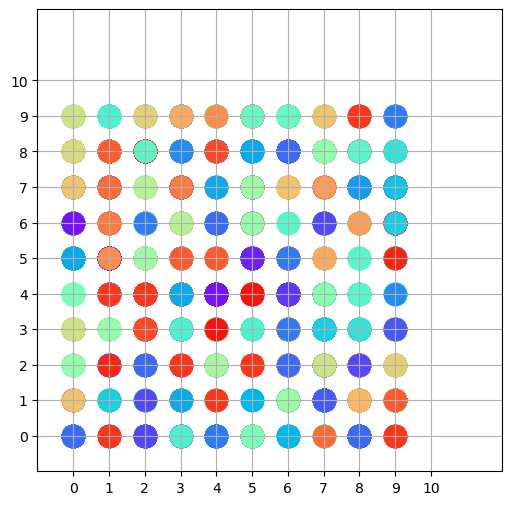

In [43]:
from matplotlib import pyplot as plt
plt.figure(figsize=(6, 6))
for i, article in enumerate(df["processed_abstract"]):
    winner = som.winner(feature_vectors[i])
    plt.scatter(winner[0], winner[1],s = 250, color=plt.cm.rainbow(topic_assignments[i] / num_topics))
    #plt.text(winner[0], winner[1], str(topic_assignments[i]), color=plt.cm.rainbow(topic_assignments[i] / num_topics))
    
plt.xticks(np.arange(11))
plt.yticks(np.arange(11))
plt.grid()
plt.xlim(-1, 12)
plt.ylim(-1, 12)
plt.show()

#### Unlike supervised learning algorithms, Latent Dirichlet Allocation (LDA) is an unsupervised algorithm, meaning it doesn't have a target variable to predict, and therefore, there is no concept of accuracy in the traditional sense. Instead, the evaluation of an LDA model typically involves assessing the quality of the topics it discovers and how well it fits the data.

We can check the coherence score for the same, which is a measure used to evaluate the quality of the topics generated by the model

In [44]:
# Creating a coherence model
coherence_model_lda = CoherenceModel(model=lda_model, texts=df["processed_abstract"].tolist(), dictionary=dictionary,coherence ="c_v")

# Calculating the coherence score
with np.errstate(invalid='ignore'):
    coherence_lda = coherence_model_lda.get_coherence()

print('Coherence Score:', coherence_lda)

Coherence Score: nan
